In [1]:
%pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

  Using cached tensorflow-2.4.1-cp38-cp38-win_amd64.whl (370.7 MB)
  Using cached tensorflow_gpu-2.4.1-cp38-cp38-win_amd64.whl (370.7 MB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
  Using cached matplotlib-3.7.5-cp38-cp38-win_amd64.whl (7.5 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached h5py-2.10.0-cp38-cp38-win_amd64.whl (2.5 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached wrapt-1.12.1.tar.gz (27 kB)
  Using cached tensorboard-2.14.0-py3-none-any.whl (5.5 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached wheel-0.45.1-py3-none-any.whl (72 kB)
  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)
  Using cached tensorflow

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress t

In [5]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [6]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [7]:
#avoiding out of memory error by setting max GPU consumption growth
#firsly check even if your device has GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
#setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')

In [9]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANCHOR_PATH, exist_ok=True)

In [10]:
# http://vis-www.cs.umass.edu/lfw/
%pip install scikit-learn
from sklearn.datasets import fetch_lfw_people
data = fetch_lfw_people(min_faces_per_person=70, resize=0.4)


You should consider upgrading via the 'c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


In [4]:
#VGGFace2-HQ dataset
#https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/
#https://www.kaggle.com/datasets/hearfool/vggface2
%pip install kagglehub
import kagglehub

# Download latest version of VGGFace2-HQ dataset
path = kagglehub.dataset_download("hearfool/vggface2")
print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.32G/2.32G [02:43<00:00, 15.3MB/s]

Extracting model files...


Path to dataset files: C:\Users\Lenovo\.cache\kagglehub\datasets\hearfool\vggface2\versions\1


In [16]:
# MOVE (cut/paste) images from TEST folder only - NO COPYING
import shutil

# Source path - ONLY TEST FOLDER
SOURCE_PATH = r'C:\Users\Lenovo\.cache\kagglehub\datasets\hearfool\vggface2\versions\1\train'
NEG_PATH = r'D:\face recognizer\face-recognition-ML\data\negative'

# Create destination directory
os.makedirs(NEG_PATH, exist_ok=True)

# Counter for moved images
moved_count = 0

print(f"Starting to MOVE (cut/paste) images from TEST folder: {SOURCE_PATH}")
print("WARNING: This will MOVE files (not copy) - original files will be deleted!")

try:
    # Check if test folder exists
    if os.path.exists(SOURCE_PATH):
        print(f"Processing TEST folder only...")
        
        # Iterate through person directories in test folder
        for person_dir in os.listdir(SOURCE_PATH):
            person_path = os.path.join(SOURCE_PATH, person_dir)
            
            # Check if it's actually a directory
            if os.path.isdir(person_path):
                print(f"  Moving files from person: {person_dir}")
                
                # Iterate through actual image files
                for file in os.listdir(person_path):
                    # Create full file path
                    file_path = os.path.join(person_path, file)
                    
                    # Check if it's an image file
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        try:
                            # Create destination path in negative folder
                            dest_filename = f"{person_dir}_{file}"  # Prefix with person directory name
                            dest_path = os.path.join(NEG_PATH, dest_filename)
                            
                            # MOVE the file (cut/paste) - this deletes the original
                            shutil.move(file_path, dest_path)
                            moved_count += 1
                            
                            if moved_count % 100 == 0:  # Progress update every 100 files
                                print(f"    Moved {moved_count} images...")
                                
                        except Exception as e:
                            print(f"    Error moving {file}: {e}")
                
                # Remove empty person directory after moving all files
                try:
                    if not os.listdir(person_path):  # If directory is empty
                        os.rmdir(person_path)
                        print(f"    Removed empty directory: {person_dir}")
                except Exception as e:
                    print(f"    Could not remove directory {person_dir}: {e}")
    else:
        print(f"TEST folder not found: {SOURCE_PATH}")
        print("Available folders:")
        base_path = r'C:\Users\Lenovo\.cache\kagglehub\datasets\hearfool\vggface2\versions\1'
        if os.path.exists(base_path):
            for folder in os.listdir(base_path):
                print(f"  - {folder}")
                
except FileNotFoundError:
    print(f"Source path not found: {SOURCE_PATH}")
except Exception as e:
    print(f"Error accessing source directory: {e}")

print(f"FINISHED! Total images MOVED: {moved_count}")
print(f"Images moved to: {NEG_PATH}")
print("Original files have been deleted (moved, not copied)")


Starting to MOVE (cut/paste) images from TEST folder: C:\Users\Lenovo\.cache\kagglehub\datasets\hearfool\vggface2\versions\1\train
Processing TEST folder only...
  Moving files from person: n000002
    Moved 100 images...
    Moved 200 images...
    Moved 300 images...
    Removed empty directory: n000002
  Moving files from person: n000003
    Moved 400 images...
    Moved 500 images...
    Removed empty directory: n000003
  Moving files from person: n000004
    Moved 600 images...
    Moved 700 images...
    Moved 800 images...
    Moved 900 images...
    Removed empty directory: n000004
  Moving files from person: n000005
    Moved 1000 images...
    Moved 1100 images...
    Removed empty directory: n000005
  Moving files from person: n000006
    Moved 1200 images...
    Moved 1300 images...
    Moved 1400 images...
    Moved 1500 images...
    Moved 1600 images...
    Removed empty directory: n000006
  Moving files from person: n000007
    Moved 1700 images...
    Moved 1800 images

In [14]:
def preprocess_images(source_folder, target_size=(250, 250)):
    
    """
    Resize all images in a folder to target size using OpenCV
    """
    processed_count = 0
    
    print(f"Preprocessing images in: {source_folder}")
    print(f"Target size: {target_size}")
    
    if not os.path.exists(source_folder):
        print(f"Folder not found: {source_folder}")
        return
    
    # Get all image files
    image_files = [f for f in os.listdir(source_folder) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    print(f"Found {len(image_files)} image files")
    
    for filename in image_files:
        try:
            # Read image
            img_path = os.path.join(source_folder, filename)
            img = cv2.imread(img_path)
            
            if img is not None:
                # Resize image
                resized_img = cv2.resize(img, target_size)
                
                # Save back to same location (overwrite)
                cv2.imwrite(img_path, resized_img)
                processed_count += 1
                
                if processed_count % 100 == 0:
                    print(f"Processed {processed_count} images...")
                    
            else:
                print(f"Could not read image: {filename}")
                
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    
    print(f"Finished! Processed {processed_count} images")

# Process negative data folder
NEG_PATH = r'D:\face recognizer\face-recognition-ML\data\negative'
preprocess_images(NEG_PATH, target_size=(250, 250))

Preprocessing images in: D:\face recognizer\face-recognition-ML\data\negative
Target size: (250, 250)
Found 176398 image files
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...
Processed 1100 images...
Processed 1200 images...
Processed 1300 images...
Processed 1400 images...
Processed 1500 images...
Processed 1600 images...
Processed 1700 images...
Processed 1800 images...
Processed 1900 images...
Processed 2000 images...
Processed 2100 images...
Processed 2200 images...
Processed 2300 images...
Processed 2400 images...
Processed 2500 images...
Processed 2600 images...
Processed 2700 images...
Processed 2800 images...
Processed 2900 images...
Processed 3000 images...
Processed 3100 images...
Processed 3200 images...
Processed 3300 images...
Processed 3400 images...
Processed 3500 images...
Process

In [11]:
# Import uuid library to generate unique image names
import uuid
ANC_PATH = r'D:\face recognizer\face-recognition-ML\data\anchor'
POS_PATH = r'D:\face recognizer\face-recognition-ML\data\positive'


In [12]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'D:\\face recognizer\\face-recognition-ML\\data\\anchor\\e11093fa-76c8-11f0-8df8-5800e3e68d5e.jpg'

In [14]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(1)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

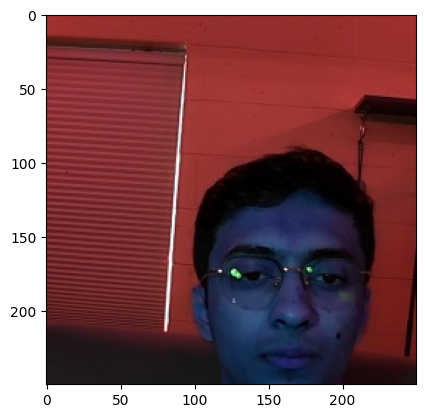

In [15]:
plt.imshow(frame)
frame.shape
plt.imshow(frame[:250, :250, :])

NEW - Data Augmentation


In [16]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [19]:
img_path = os.path.join(ANC_PATH, '1ae75233-7471-11f0-b02e-5800e3e68d5e.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [27]:
# Define directory paths
ANCHOR_DIR = r'D:\face recognizer\face-recognition-ML\data\anchor'
POSITIVE_DIR = r'D:\face recognizer\face-recognition-ML\data\positive'
NEGATIVE_DIR = r'D:\face recognizer\face-recognition-ML\data\negative'

# Get lists of image files and limit to 300 each
anchor_files = os.listdir(ANCHOR_DIR)[:3000]
positive_files = os.listdir(POSITIVE_DIR)[:3000]
negative_files = os.listdir(NEGATIVE_DIR)[:3000]

# Create full file paths for the datasets
anchor = [os.path.join(ANCHOR_DIR, f) for f in anchor_files]
positive = [os.path.join(POSITIVE_DIR, f) for f in positive_files]
negative = [os.path.join(NEGATIVE_DIR, f) for f in negative_files]

print(f"Loaded {len(anchor)} anchor images")
print(f"Loaded {len(positive)} positive images")
print(f"Loaded {len(negative)} negative images")

Loaded 3000 anchor images
Loaded 3000 positive images
Loaded 3000 negative images


In [28]:
# Create labeled dataset
# Make sure we have equal numbers of anchor and positive/negative images
min_length = min(len(anchor), len(positive), len(negative))
anchor = anchor[:min_length]
positive = positive[:min_length]
negative = negative[:min_length]

print(f"Using {min_length} images for each category")

# Create labels
positive_labels = tf.ones(len(anchor))
negative_labels = tf.zeros(len(anchor))

# Create positive and negative datasets  
positive_ds = tf.data.Dataset.from_tensor_slices((anchor, positive, positive_labels))
negative_ds = tf.data.Dataset.from_tensor_slices((anchor, negative, negative_labels))

# Concatenate them
data = positive_ds.concatenate(negative_ds)

print(f"Dataset created with {len(anchor) * 2} total samples")


Using 3000 images for each category
Dataset created with 6000 total samples


In [25]:
# Simple preprocessing function
def preprocess_image(file_path):
    """Load and preprocess a single image"""
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (100, 100))
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Create a simple dataset from file paths - NO COMPLEX PREPROCESSING NEEDED
# Make sure we have equal numbers for each category
min_length = min(len(anchor), len(positive), len(negative))
print(f"Using {min_length} images for each category")

anchor = anchor[:min_length]
positive = positive[:min_length]
negative = negative[:min_length]

# Create datasets from file paths
positive_ds = tf.data.Dataset.from_tensor_slices((anchor, positive))
negative_ds = tf.data.Dataset.from_tensor_slices((anchor, negative))

# Add labels
positive_ds = positive_ds.map(lambda a, p: (a, p, 1.0))  # Same person = 1
negative_ds = negative_ds.map(lambda a, n: (a, n, 0.0))  # Different person = 0

# Combine datasets
data = positive_ds.concatenate(negative_ds)

print(f"Total dataset size: {min_length * 2} image pairs")


Using 565 images for each category
Total dataset size: 1130 image pairs


In [61]:
# SIMPLE WORKING FIX: Load all images into memory first (simpler approach)
def load_images_into_memory():
    """Load all images into memory to avoid tf.py_function issues"""
    print("Loading images into memory...")
    
    # Load anchor images
    anchor_images = []
    for path in anchor:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (100, 100))
            img = img.astype(np.float32) / 255.0
            anchor_images.append(img)
        else:
            print(f"Failed to load: {path}")
    
    # Load positive images  
    positive_images = []
    for path in positive:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (100, 100))
            img = img.astype(np.float32) / 255.0
            positive_images.append(img)
    
    # Load negative images
    negative_images = []
    for path in negative:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (100, 100))
            img = img.astype(np.float32) / 255.0
            negative_images.append(img)
    
    print(f"Loaded {len(anchor_images)} anchor, {len(positive_images)} positive, {len(negative_images)} negative images")
    return np.array(anchor_images), np.array(positive_images), np.array(negative_images)

# Load all images into memory
anchor_imgs, positive_imgs, negative_imgs = load_images_into_memory()

# Make sure we have equal numbers
min_length = min(len(anchor_imgs), len(positive_imgs), len(negative_imgs))
anchor_imgs = anchor_imgs[:min_length]
positive_imgs = positive_imgs[:min_length]
negative_imgs = negative_imgs[:min_length]

# Create positive and negative pairs with labels
positive_pairs = tf.data.Dataset.from_tensor_slices((anchor_imgs, positive_imgs, tf.ones(min_length)))
negative_pairs = tf.data.Dataset.from_tensor_slices((anchor_imgs, negative_imgs, tf.zeros(min_length)))

# Combine datasets
data = positive_pairs.concatenate(negative_pairs)

# Shuffle and split the data
data = data.shuffle(buffer_size=1024)  # Reduced buffer size for stability
dataset_size = min_length * 2

# Split into train (70%) and test (30%)
train_size = int(0.7 * dataset_size)
test_size = dataset_size - train_size

train_data = data.take(train_size)
test_data = data.skip(train_size)

# Batch and prefetch for performance
train_data = train_data.batch(16).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(16).prefetch(tf.data.AUTOTUNE)

print(f"Training batches: {train_size // 16}")
print(f"Testing batches: {test_size // 16}")
print("Dataset ready for training!")


Loading images into memory...
Loaded 3000 anchor, 3000 positive, 3000 negative images
Training batches: 262
Testing batches: 112
Dataset ready for training!


Batch shape: anchor=(16, 100, 100, 3), comparison=(16, 100, 100, 3), labels=(16,)
Sample labels: [1. 1. 1. 1. 1.]


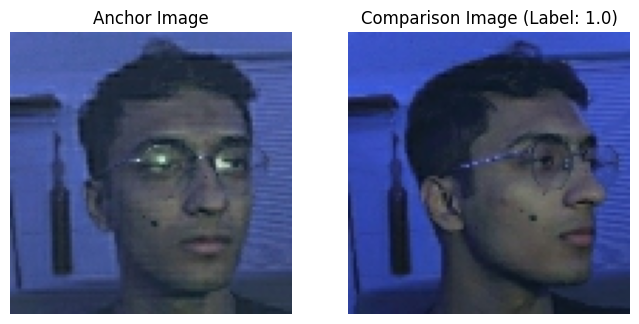

In [62]:
# Optional: Test the dataset by showing a sample
sample_batch = next(iter(train_data))
print(f"Batch shape: anchor={sample_batch[0].shape}, comparison={sample_batch[1].shape}, labels={sample_batch[2].shape}")
print(f"Sample labels: {sample_batch[2][:5].numpy()}")  # Show first 5 labels

# Show a sample pair
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_batch[0][0])  # First anchor image
plt.title('Anchor Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_batch[1][0])  # First comparison image
plt.title(f"Comparison Image (Label: {sample_batch[2][0].numpy()})")
plt.axis('off')
plt.show()


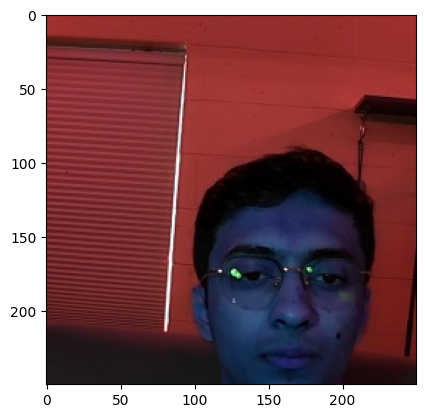

In [63]:
plt.imshow(frame)

In [64]:
samples = data.as_numpy_iterator()

In [65]:
len(samples.next())

3

In [66]:
#training algorithm
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [67]:
train_samples = train_data.as_numpy_iterator()

In [68]:
train_samples = train_samples.next()

In [69]:
#testing Algorithm
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [70]:
#Build embedding layer
def make_embedding_model():
    inp  = Input(shape=(100,100,3), name='input_img')
    
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)
    
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [71]:
embedding = make_embedding_model()

In [72]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [78]:
# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

# Check if L1Dist is already registered and clear it if needed
import tensorflow.keras.utils as utils
if hasattr(utils, '_GLOBAL_CUSTOM_OBJECTS'):
    if 'Custom>L1Dist' in utils._GLOBAL_CUSTOM_OBJECTS:
        print("L1Dist already registered, removing...")
        del utils._GLOBAL_CUSTOM_OBJECTS['Custom>L1Dist']
    if 'L1Dist' in utils._GLOBAL_CUSTOM_OBJECTS:
        print("L1Dist already registered, removing...")
        del utils._GLOBAL_CUSTOM_OBJECTS['L1Dist']


TensorFlow version: 2.4.1
Keras version: 2.4.0


In [76]:
# Build distance layer - FIXED for re-running cells
# Check if L1Dist is already defined to avoid re-registration errors
if 'L1Dist' not in globals():
    print("Defining L1Dist class...")
    
    @tf.keras.utils.register_keras_serializable()
    class L1Dist(Layer):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            
        def call(self, inputs, **kwargs):
            x, y = inputs
            return tf.math.abs(x - y)
        
        # help legacy shape inference
        def compute_output_shape(self, input_shape):
            return input_shape[0]
        
        def get_config(self):
            return super().get_config()
else:
    print("L1Dist already exists, using existing definition")

# Create instance
l1 = L1Dist()
print(f"L1Dist instance created: {l1}")

L1Dist already exists, using existing definition
L1Dist instance created: <__main__.L1Dist object at 0x000002189352D190>


Make Siamese Model

In [79]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer([inp_embedding, val_embedding])
classifier = Dense(1, activation='sigmoid')(distances)
classifier


<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_4')>

In [83]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [84]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_8 (L1Dist)              (None, 4096)         0           embedding[4][0]     

Training

In [85]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[8][0]     

In [86]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [87]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [88]:
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
os.makedirs(checkpoint_dir, exist_ok=True)

# Track an integer epoch variable inside the checkpoint to resume
checkpoint = tf.train.Checkpoint(siamese_model=siamese_model, opt=opt, epoch=tf.Variable(0, dtype=tf.int64))
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [89]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
X = batch_1[:2]
y = batch_1[2]
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [90]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        #get anchor, positive, negative image
        x = batch[ :2]
        #get label
        y = batch[2]
        
        #forward pass
        yhat = siamese_model(x, training = True)
        
        #calculate loss
        loss = binary_cross_loss(y, yhat)
        tf.print(loss)
        
        #calculate gradients
        grad = tape.gradient(loss, siamese_model.trainable_variables)
        
        #update weights
        opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [91]:
def train(data, EPOCHS):
    """Custom training loop with per-epoch checkpointing and resume support."""
    try:
        # Determine starting epoch from checkpoint (if restored)
        start_epoch = int(checkpoint.epoch.numpy()) if hasattr(checkpoint, 'epoch') else 0
        if start_epoch > 0:
            print(f"Resuming training from epoch {start_epoch + 1}")
        
        # Iterate from next epoch up to EPOCHS
        for epoch in range(start_epoch + 1, EPOCHS + 1):
            print(f"\n Epoch {epoch}/{EPOCHS}")
            progbar = tf.keras.utils.Progbar(len(data))

            # Loop through each batch
            for idx, batch in enumerate(data):
                train_step(batch)
                progbar.update(idx + 1)

            # Increment and save checkpoint after each epoch
            if hasattr(checkpoint, 'epoch'):
                checkpoint.epoch.assign_add(1)
            if 'manager' in globals():
                save_path = manager.save()
                print(f"Saved checkpoint to {save_path} (epoch={int(checkpoint.epoch.numpy())})")
            else:
                # Fallback to direct checkpoint save
                checkpoint.save(file_prefix=checkpoint_prefix)
    
    except KeyboardInterrupt:
        print("\nTraining interrupted by user. Saving checkpoint and model...")
        if 'manager' in globals():
            save_path = manager.save()
            print(f"Checkpoint saved to {save_path}")
        else:
            checkpoint.save(file_prefix=checkpoint_prefix)
        try:
            siamese_model.save("my_model_checkpoint_interrupt")
            print("Model saved to my_model_checkpoint_interrupt")
        except Exception as e:
            print(f"Model save failed: {e}")
        # Return gracefully
        return
            

In [92]:
EPOCHS = 50

In [93]:
# Restore latest checkpoint if available and continue training
latest_ckpt = manager.latest_checkpoint
if latest_ckpt:
    checkpoint.restore(latest_ckpt)
    print(f"Restored from {latest_ckpt} (epoch={int(checkpoint.epoch.numpy())})")
else:
    print("No checkpoint found, starting from scratch.")

# Continue training from restored epoch
train(train_data, EPOCHS)

# Save final model at end
try:
    siamese_model.save("my_model_checkpoint")
    print("Final model saved to my_model_checkpoint")
except Exception as e:
    print(f"Final model save failed: {e}")


Restored from ./training_checkpoints\ckpt-50 (epoch=50)
Resuming training from epoch 51
INFO:tensorflow:Assets written to: my_model_checkpoint\assets
Final model saved to my_model_checkpoint


Evaluate Model

In [94]:
#import metric calculation
from tensorflow.keras.metrics import Precision, Recall


In [95]:
#get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [96]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[2.3196198e-07],
       [1.7467141e-04],
       [5.0062275e-01],
       [5.1674247e-04],
       [5.5079564e-08],
       [1.0983709e-04],
       [2.1973252e-04],
       [1.3873220e-06],
       [3.5887970e-07],
       [3.3651904e-06],
       [4.4499934e-02],
       [2.7912766e-02],
       [2.6834114e-08],
       [1.5130639e-04],
       [9.5564898e-09],
       [5.6058377e-07]], dtype=float32)

In [97]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [98]:
#creating metric object
m = Recall()

#calculate the recall value
m.update_state(y_true, y_hat)

# return result
m.result().numpy()

1.0

In [99]:
#creating metric object
m = Precision()

#calculate the recall value
m.update_state(y_true, y_hat)

# return result
m.result().numpy()

1.0

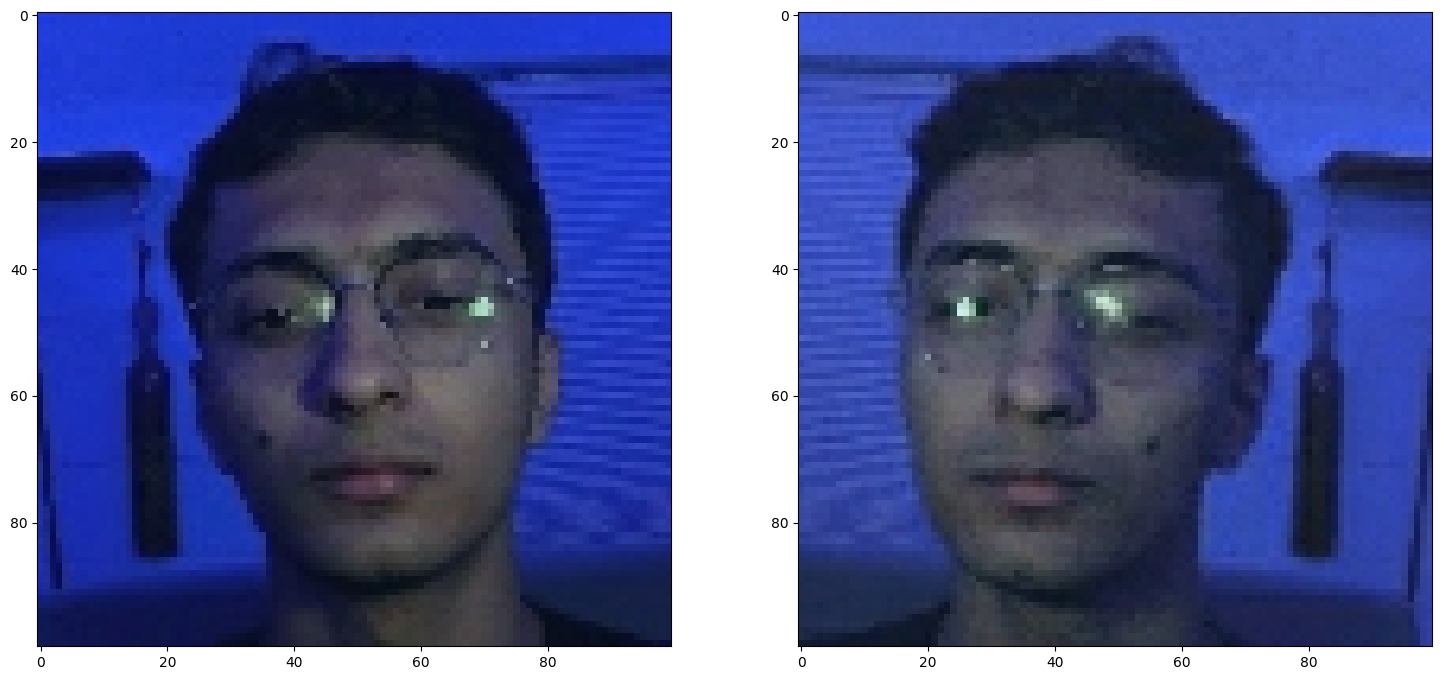

In [106]:
#viz results
#set plot size
plt.figure(figsize=(18, 18))
#plot the first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[2])

#set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[2])
plt.show()

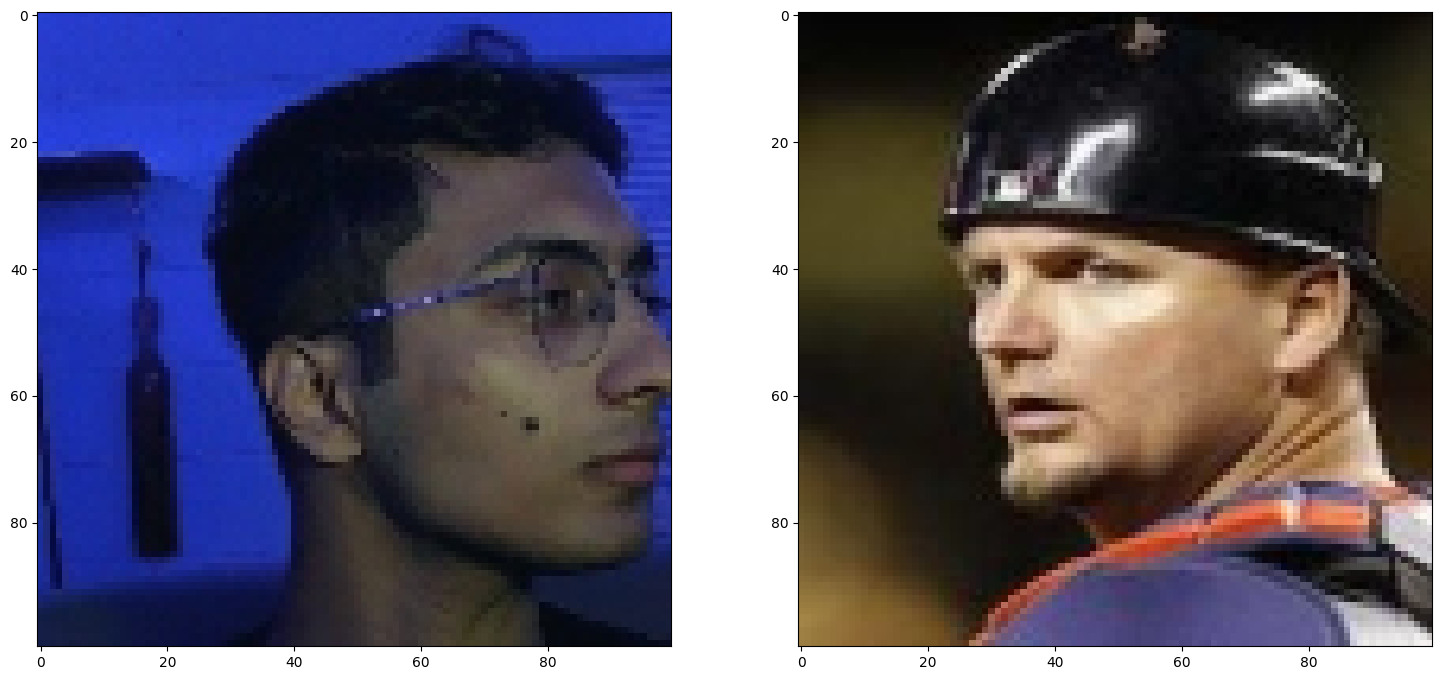

In [103]:

#set plot size
plt.figure(figsize=(18, 18))
#plot the first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])

#set second subplot
plt.subplot(1, 2, 2)
plt.imshow(test_val[0])
plt.show()

Save Model 

In [107]:
#save weights
siamese_model.save('siamese_model.h5')

In [108]:
#reload model
model = tf.keras.models.load_model('siamese_model.h5', custom_objects={'L1Dist': L1Dist, 'binaryCrossentropy': tf.keras.losses.BinaryCrossentropy})

In [109]:
#make predictions with the reloaded model
model.predict([test_input, test_val])

array([[2.3196198e-07],
       [1.7467141e-04],
       [5.0062275e-01],
       [5.1674247e-04],
       [5.5079564e-08],
       [1.0983709e-04],
       [2.1973252e-04],
       [1.3873220e-06],
       [3.5887970e-07],
       [3.3651904e-06],
       [4.4499934e-02],
       [2.7912766e-02],
       [2.6834114e-08],
       [1.5130639e-04],
       [9.5564898e-09],
       [5.6058377e-07]], dtype=float32)

In [110]:
#view model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[0][0]     

Real time prediction Test with open cv

In [111]:
#verification function
def verify(model, detection_threshold, verification_threshold):
    #build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess_image(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess_image(os.path.join('application_data', 'verification_images', image))

        #make predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    #Detection threshold: Metric above which a detection is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    #Verification threshold: portion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified   

opencv Real Time  Verification

In [112]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    cv2.imshow('Verification', frame)
    
    #verification trigger, similar to you hitting your power button twice on your iphone
    if cv2.waitKey(1) & 0xFF == ord('v'):
        #save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', f'input_image.jpg'), frame)
        #run verification
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

False
True
False
True
False


In [117]:
np.sum(np.squeeze(results))

0.017817793

In [114]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]